<a href="https://colab.research.google.com/github/hughes28/SimulatedAnnealing/blob/master/SimulatedAnnealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Branin Function Minima Determination via Simulated Annealing

## Introduction

### **Simulated annealing** is a powerful metaheuristic technique used to find the optima in multidimensional objective functions (e.g. f(x, y) == z). 
<br>

### It iterates through several "temperatures" and slowly "cools off" as it iterates to find a minimum throughout the objective function's domain. At each temperature, it attempts to find N neighbors to figure out if, by slightly increasing or decreasing either x or y, an optimal solution of f(x, y) can be found. If f(x, y) is more optimal, it is saved through the iterations. If f(x, y) is initially not found to be optimal, it also goes through a temperature equation (based on RNG, current temperature/input values) and if a random generated number is below the output of this temperature equation, it accepts the new f(x, y). This pattern repeats through new temperatures that are generated through a decay constant alpha. 
<br>

### 100 starting points of minima are generated for this algorithm throughout the domain of the objective function as there are multiple minima that each starting point could fall into. The minima that are calculated are then ordered and the lowest value of f(x, y) from the minima is determined to be the **global minimum value**. This algorithm shows both the local minima and global minimum in the objective function through a 3-D graph.

### To add a challenge, the objective function used is the Branin02 function, which has a success rate (according to src: http://infinity77.net/global_optimization/test_functions.html) of roughly 23.5%. Despite this, this simulated annealing algorithm is still able to determine the global optimum with ease.

## 1. Define all libraries and variables

### Standard math/graphing libraries along with hyperparameter constants used in the simulated annealing algorithm.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # graphing utility
import numpy as np # array generation/manipulation
import pandas as pd # data manipulation/storage

# Ignores warnings flagged during minima finding.
import warnings
warnings.filterwarnings("ignore", message="overflow encountered in exp")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Simulated annealing hyperparameters:
T_0 = 1000 # starting "temperature" of the simulated annealing algorithm
M = 200 # the number of temperatures to be iterated through
N = 100 # the number of neighbors to find at each temperature
ALPHA = 0.9 # decay constant to decrease each temperature at 
K = 0.2 # used to determine how large step-size magnitude is 

# Function domain:
DOMAIN_Y = [-5, 15]
DOMAIN_X = [-5, 15]

# How many minima per unit domain X & Y:
RES = 1

# How many starting points to calculate minima from:
MAX_NUMBER_OF_STARTING_POINTS = 100

## 2. Prepare objective function

### 2.1 Define objective function

#### This is the function in question in terms of x and y that will have its minima found. In this case, the Branin function is used and, to increase difficulty, there are multiple minima that are in the function but only one global minima.

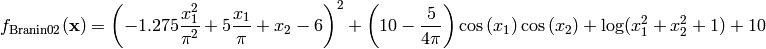

#### where x_1 == x and x_2 == y. 

In [2]:
def objective_function(x, y):
    # Branin function (src: http://infinity77.net/global_optimization/test_functions.html)
    return (-1.275*(x**2)/(np.pi)**2 + (5*x)/np.pi + y - 6)**2 + (10-5/(4*np.pi))*np.cos(x)*np.cos(y)+np.log(x**2 + y**2 + 1) + 10

### 2.2 Show objective function 

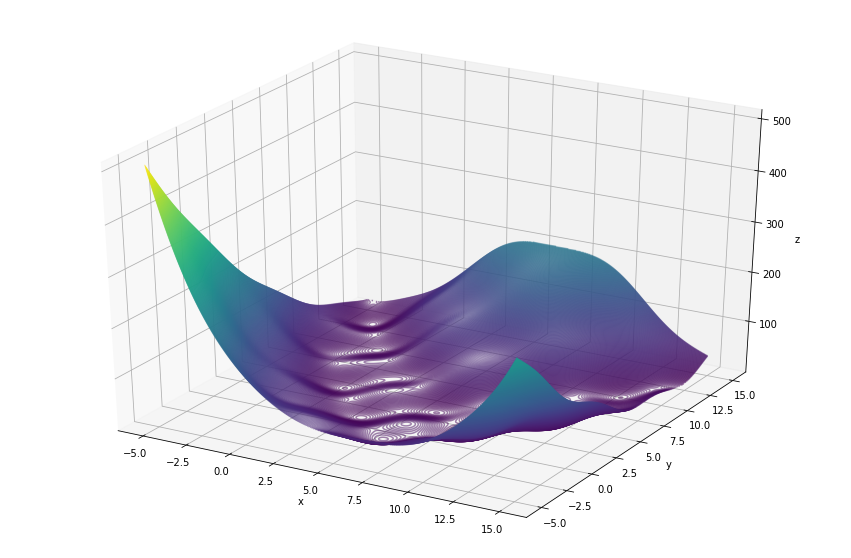

In [3]:
def plot_3D_map(x_range=DOMAIN_X, y_range=DOMAIN_Y, input_minima=None):
    # Create x/y numpy arrays and generate a mesh grid for the two of them.
    # Change resolution of grid below if bigger domain is used.
    x = np.arange(x_range[0], x_range[1] + 0.05, 0.05)
    y = np.arange(y_range[0], y_range[1] + 0.05, 0.05)

    # Evaluate Z using the X and Y mesh grids.
    X, Y = np.meshgrid(x, y)
    Z = objective_function(X, Y)

    # Generate the plot. 
    fig = plt.figure(figsize=(15,10))
    axes = plt.axes(projection='3d')

    # Default if there are no minima.
    alpha = 0.5
    
    # If there is an input for minima:
    if input_minima: 
        # Sort optimal values tuples by z. The first value is the global optimum.
        input_minima.sort(key=lambda tup: tup[2])

        # Changes alpha to lower value so minima can be seen more easily.
        alpha = 0.01

        # The  x, y, and f(x, y) values are taken from the input minima.
        x_val = [minimum[0] for minimum in input_minima]
        y_val = [minimum[1] for minimum in input_minima]
        z_val = [minimum[2] for minimum in input_minima]

        # All of the minima are graphed in a transparent red.
        axes.scatter3D(x_val, y_val, z_val, color='red', alpha=0.1)

        # The global minima is graphed in a distinguishing green color.
        axes.scatter3D(x_val[0], y_val[0], z_val[0], color='#006400', marker='x', s=100)  

    # Graph the plot.       
    axes.contour3D(X, Y, Z, 980, alpha=alpha)
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_zlabel("z")
    plt.show()

    # Print global minima with coordinates.
    if input_minima:
        print('Global minimum:')
        print(f'    {z_val[0]} @ f({x_val[0]}, {y_val[0]})')
        print('')
        print('Local minima:')
        for i in range(1, len(x_val)-1):
            print(f'    {z_val[i]} @ f({x_val[i]}, {y_val[i]})')

plot_3D_map()

## 3. Set up optimum arrays and required functions

### 3.1. Generate potential starting points of minima and optimial x, y, and z arrays

#### The range of x and y values along with the returned minima arrays of x, y, and z are calculated. More than one x and y pair is used because there is more than one minima.

In [4]:
# Generate minima starting points.
x_range = np.arange(DOMAIN_X[0], DOMAIN_X[1] + RES, RES)
y_range = np.arange(DOMAIN_Y[0], DOMAIN_Y[1] + RES, RES)

# Generate empty x, y, and calculated z arrays for minima.
optimal_x_values = []
optimal_y_values = []
optimal_z_values = []

### 3.2. Create "mover" function

#### This function generates new values of x and y that are slightly larger or smaller than the original values via use of RNG. It is referenced in the function which finds the minima later.

In [5]:
def generate_step_size(var):
    # Determines if step-size is negative or positive.
    random_num_1 = np.random.rand()

    # Determintes magnitude of step-size.
    random_num_2 = np.random.rand()

    if random_num_1 <= 0.5:
        step_size = K * random_num_2
    else:
        step_size = -K * random_num_2

    return step_size

### 3.3. Create minima-finding function

#### This function will be used along with the generate_step_size function to find the minima for an (x, y) pair plugged into it.

In [6]:
def find_minimum(x, y, T_0):
    # z is defined outside loop to keep track of optimal z value.
    z = objective_function(x, y)

    for m in range(M):
        for n in range(N):
            # Generates potential new optimal input values and corresponding output.
            x_new = x + generate_step_size(x) 
            y_new = y + generate_step_size(y) 
            z_new = objective_function(x_new, y_new)
            z = objective_function(x, y)

            # Generates random number to be compared with temperature equation.
            rand_num = np.random.rand()
            temp_eq = 1/(np.exp((z_new - z)/T_0))

            # If the new output z is lower than the original, the new x and y is stored. 
            if z_new <= z:
                x = x_new
                y = y_new
            # If the resultant of the temperature equation is more than a random number.
            elif rand_num <= temp_eq:
                x = x_new
                y = y_new

        # Reduce temperature via alpha.  
        T_0 = T_0*ALPHA
    
    # Return the x, y, and z values of the calculated minimum.
    optimal_tuple = (x, y, z)
    return optimal_tuple

## 4. Generate minima

### 4.1. Find minima using random pairings of the starting point arrays.

In [7]:
# Generate minima array and starting points for the x and y variables.
optimal_values = []
starting_points = []

# Find minima until the number of starting points is reached.
minima_calculated = 0
while minima_calculated < MAX_NUMBER_OF_STARTING_POINTS:
    # Choose random x and y from generated starting points.
    x = np.random.choice(x_range)
    y = np.random.choice(y_range)
    starting_point = (x, y)
    # Find the minimum if the starting point isn't already in the starting points array.
    if starting_point not in starting_points:
        output = find_minimum(x, y, T_0)
        optimal_values.append(output)
        minima_calculated += 1

        # Add starting point used to starting points array to ensure no repeats.
        starting_points.append(starting_point)

# Sort optimal values tuples by x.
optimal_values.sort(key=lambda tup: tup[0])

### 4.2. Process calculated minima and average similar ones to condense array of minima

#### Because the calculated minima will be very similar to one another but not quite equal, the sorted array of tuples is looped through and, once the x-value is a certain percent difference compared to the first value, that x-value and all of the previous values are averaged together and output as one minima to be graphed. The process is repeated until there are no more minima in the optimal values array of tuples.

In [8]:
# Percent difference required to move onto next minima to be plotted.
PERCENT_DIFFERENCE = 0.05

# Generate minima to be graphed array.
minima = []

# Generate temporary arrays to calcuate averaged minima.
x_array = []
y_array = []
z_array = []

# The index of the previous minimum appeneded to the temporary array is tracked.
previous_index = 0

# If it's the first loop of a new averaged minimum to be calculated, the values
# are automatically added to the temporary arrays.
first_loop = True

# The number of outputs processed in the for loop is tracked.
output_number = 0

# If there are no more minima to be processed in optimal_values, the quit flag triggers.
quit_flag = False

# Loops through all of the tuples in optimal_values.
for output in optimal_values:
    # If it is the first loop regarding a specific minimum, 
    # the values are automatically added to the temporary array.
    if first_loop:
        x_array.append(output[0])
        y_array.append(output[1])
        z_array.append(output[2])
        first_loop = False

        # The total number of processed minima is tracked through output_number.
        output_number += 1
    else:
        # The absolute value of the percent change in x is calculated using the current output x value
        # and the x value in the previous output.
        x_change = abs((output[0] - x_array[previous_index]) / x_array[previous_index])

        # If the calculated percent change is greater than the set percent difference:
        if x_change > PERCENT_DIFFERENCE:
            # Calculate the averaged minima value and round values.
            minimum = (round(np.mean(x_array),5), 
                       round(np.mean(y_array),5), 
                       round(np.mean(z_array),5))
            
            # Append averaged minimum to the minima array.
            minima.append(minimum)

            # Reset the temporary x, y, and z arrays.
            x_array = []
            y_array = []
            z_array = []

            # Reset previous_index to 0 (as a new minimum will be started).
            previous_index = 0

            # Reset first_loop boolean to True to ensure the first set of x, y,
            # and z values are automatically added to the temporary array.
            first_loop = True

            output_number += 1
        # Append the x, y, and z values of the current minimum to the temporary 
        # arrays if the percent difference is less than the set percent difference.
        else: 
            x_array.append(output[0])
            y_array.append(output[1])
            z_array.append(output[2])
            previous_index += 1
            output_number += 1

        # Check to see if the next minimum in the array exists: 
        try:
            exists = optimal_values[output_number + 1]
        # If it doesn't exist, it is the last minimum and the values that are
        # in the x, y, and z temporary arrays are averaged and the resultant
        # minimum is added. The quit flag is set to True to end the loop.
        except:
            minimum = (round(np.mean(x_array),5), 
                       round(np.mean(y_array),5), 
                       round(np.mean(z_array),5))
            minima.append(minimum)
            quit_flag = True
        
        # If the except block above is triggered, the loop ends.
        if quit_flag:
            break

### 4.3. Filter minima

#### The calculated minima are all ensured to be within 10% of the domain set at the beginning of the script. This is due to the potential of the x and y values to be slightly greater than the specified domain due to rounding (if the minima is right on the boundary of the domains).

In [9]:
filtered_minima = [minimum for minimum in minima 
          if (minimum[0] >= DOMAIN_X[0]*1.10 and minimum[0] <= DOMAIN_X[1]*1.10) 
          and
          (minimum[1] >= DOMAIN_Y[0]*1.10 and minimum[1] <= DOMAIN_Y[1]*1.10)]

## 5. Graph both local (red circles) and global (green 'x') minima

### The value of the global minimum is printed below the graph. In addition, the objective function is made to be transparent so the minima can easily be seen.

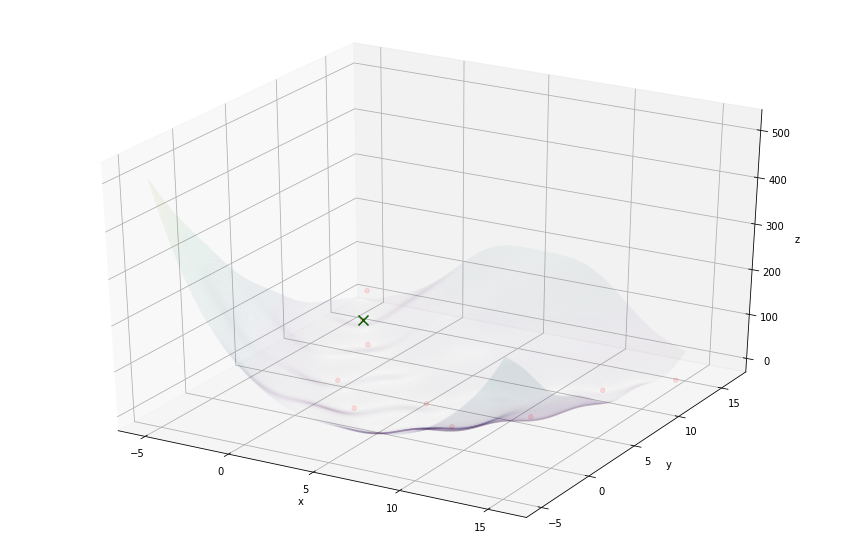

Global minimum:
    5.55899 @ f(-3.19738, 12.52557)

Local minima:
    6.43828 @ f(15.63865, 12.58302)
    6.81063 @ f(3.36356, 0.37337)
    7.70845 @ f(0.55453, 3.4925)
    7.71499 @ f(6.26328, 2.77275)
    9.3404 @ f(9.08683, 0.40813)
    10.7415 @ f(13.21556, 9.01382)
    10.97916 @ f(-0.76266, 8.90419)
    11.35545 @ f(11.89876, 3.61283)


In [10]:
plot_3D_map(input_minima=filtered_minima)

## Conclusion

### Simulated annealing is a powerful metaheuristic that has the ability to easily find both local and global minima in a multidimensional objective function. As shown in the graph above, it can easily find both local minima and the global minimum in complex objective functions that may have more than one optimal solutions.
<br>

### The solution found above matches with the literature value of the Branin02 function (as found here: http://infinity77.net/global_optimization/):
<br>

### f(x) = 5.559037 for x = [-3.2, 12.53]
<br>

### This closely matches the global minimum value found through the simulated annealing algorithm.